In [1]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm

from isca_tools.cesm import get_pressure
from isca_tools.convection.base import lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc, isel_float
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
percentile_label = 'Temperature Percentile, $x$'

In [3]:
labels_cont = {'temp_ft_change': 'FT change', 'rh_change': 'RH change', 'sCAPE_change': 'CAPE change',
               'temp_surf_anom': 'Hot-get-hotter', 'rh_anom': 'Drier-get-hotter', 'lapse_D_change': '$\eta_D$ change',
               'lapse_M_change': '$\eta_M$ change', 'lapse_D_anom': '$\eta_D$ climatological',
               'p_surf_change': '$p_s$ change', 'p_surf_anom': 'Higher-get-hotter'}
leg_handlelength = 1.5

## Load data and average over `lon_sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [4]:
%%time
p_ft_use = 400 * 100
ds = {}
for surf in ['ocean', 'land']:
    ds[surf] = xr.load_dataset(os.path.join(utils.out_dir, f"ds_tropics_{surf}.nc")).sel(p_ft=p_ft_use)
    ds[surf]['p_lnb_approx'] = get_pressure(ds[surf].PS, ds[surf].P0, ds[surf].hyam, ds[surf].hybm).isel(
        lev=ds[surf].lnb_ind)
    ds[surf]['lapse_Dz'] = ds[surf].mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
    ds[surf]['lapse_Mz'] = ds[surf].mod_parcel1_lapse.isel(layer=1) / 1000
    ds[surf]['lapse_D'] = R / g * ds[surf].TREFHT * ds[surf]['lapse_Dz']
    ds[surf]['lapse_M'] = R / g * ds[surf].T_ft_env * ds[surf]['lapse_Mz']
lat_weights = utils.lat_weights.reindex_like(ds[surf].lat).gw
temp_surf_lcl_calc = ds['ocean'].temp_surf_lcl_calc
p_ft = float(ds['ocean'].p_ft)

CPU times: user 15.8 s, sys: 4.34 s, total: 20.1 s
Wall time: 21.9 s


In [33]:
def get_ds_quant_and_ref(ds):
    mask_fit = utils.get_valid_mask(ds)

    # Get rid of variables don't need anymore - those with layer dimension
    ds = ds.drop_dims(['layer', 'lev'])

    # ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
    # Reference is computed from all days
    ds_ref = ds.mean(dim=['lon_sample', 'quant'])  # reference average over all convective days
    # For each quantile, only consider those days for which are convective. As cannot say anything about non-convective days in modParc framework
    ds_quant = ds.where(mask_fit).mean(dim='lon_sample')

    # Add standard deviation for lapse rate variables
    ds_quant_std = ds[['lapse_D', 'lapse_M']].where(mask_fit).std(dim='lon_sample')
    for key in ds_quant_std:
        ds_quant[f"{key}_std"] = ds_quant_std[key]
    return ds_quant, ds_ref
    # ds_ref = ds_quant.mean(dim='quant')  # reference, treat each quant the same so av TREFHT actuall


ds_quant = [0, 0]
ds_ref = [0, 0]
for i, surf in enumerate(ds):
    ds_quant[i], ds_ref[i] = get_ds_quant_and_ref(ds[surf])
ds_quant = xr.concat(ds_quant, dim=xr.DataArray(list(ds.keys()), dims="surf", name='surf'))
ds_ref = xr.concat(ds_ref, dim=xr.DataArray(list(ds.keys()), dims="surf", name='surf'))

In [34]:
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(co2=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(co2=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_Dz'] = ds_ref['lapse_Dz'] * 0
ds_ref['lapse_Mz'] = ds_ref['lapse_Mz'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0

# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

ds_quant = ds_quant.transpose('surf', 'co2', 'quant', 'lat', 'parcel_type')
ds_ref = ds_ref.transpose('surf', 'co2', 'lat', 'parcel_type')

## Scaling factor
I first get the scaling factor both numerically and normal linear theory, making the function work with xarray.

In [35]:
ds_sf = utils.apply_scale_factor_theory(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc=temp_surf_lcl_calc, sCAPE_form=False,
                                        numerical=False)

In [36]:
# Get total non-linear contribution due to combination of any 2 mechanisms
# ds_sf_num["nl_sum"] = ds_sf_num['scale_factor_nl'] - ds_sf_num['scale_factor_linear'] + 1
# ds_sf_num_cape["nl_sum"] = ds_sf_num_cape['scale_factor_nl'] - ds_sf_num_cape['scale_factor_linear'] + 1
#
# # Set numerical method to show difference to linear theory
# for key in ds_sf:
#     ds_sf_num[key] = ds_sf_num[key] - ds_sf[key] + 1
# for key in ds_sf_cape:
#     ds_sf_num_cape[key] = ds_sf_num_cape[key] - ds_sf_cape[key] + 1

### Theoretical scaling factor
Below I plot the theoretical scaling factor in modParc framework, also including sCAPE term as a comparison.

In [37]:
style_map = {
    # --- change (solid) ---
    "temp_ft_change": ("C2", "-", labels_cont['temp_ft_change']),
    "rh_change": ("C0", "-", labels_cont['rh_change']),
    "lapse_D_change": ("C8", "-", labels_cont['lapse_D_change']),
    "lapse_M_change": ("C1", "-", labels_cont['lapse_M_change']),
    "sCAPE_change": ("C1", ":", labels_cont['sCAPE_change']),
    "p_surf_change": ("C0", ":", labels_cont['p_surf_change']),

    # --- anomalies (dotted) ---
    "temp_surf_anom": ("C3", "-", labels_cont['temp_surf_anom']),
    "rh_anom": ("C4", "-", labels_cont['rh_anom']),
    "p_surf_anom": ("C4", ":", labels_cont['p_surf_anom']),

    # sf
    "scale_factor": ('k', "-", 'Simulated'),
    "scale_factor_sum": ('k', "--", 'Theory'),

    # non-linear
    "nl_temp_surf_anom_rh_change": ('C3', '-', '$\Delta T_s \delta r_s$'),
    "nl_rh_change_lapse_D_anom": ('C0', '-', '$\Delta \eta_D \delta r_s$'),
    "nl_temp_surf_anom_lapse_M_change": ('C1', '-', '$\Delta T_s \delta \eta_M$'),
    "nl_temp_surf_anom_sCAPE_change": ('C1', ':', '$\Delta T_s \delta sCAPE$')
}

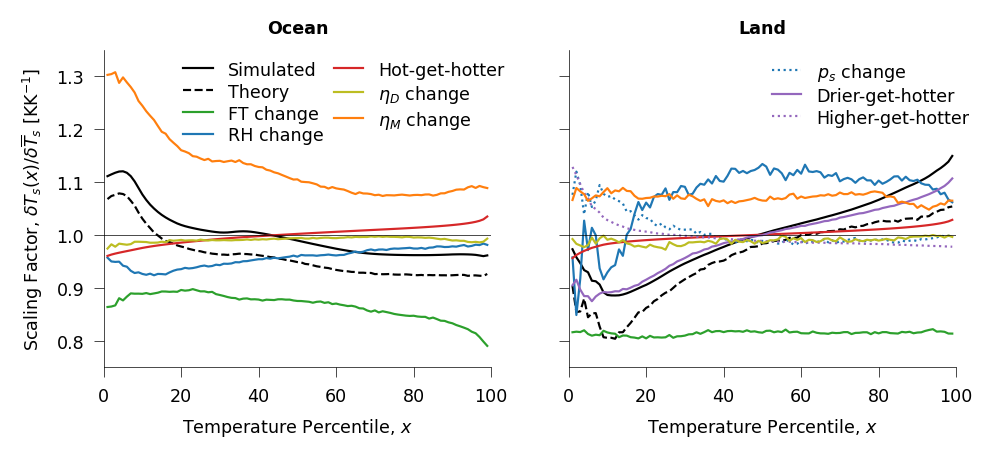

In [38]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
keys_added = []
for k in range(ds_sf.surf.size):
    ax[k].set_title(ds_sf.surf.values[k].capitalize(), fontweight='bold')
    for key in ['', '_sum']:
        ax[k].plot(ds_sf.quant, np.average(ds_sf.isel(surf=k)[f"scale_factor{key}"], axis=0, weights=lat_weights),
                   color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
                   label=style_map[f"scale_factor{key}"][2] if k==0 else None)
    # ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[f"scale_factor_sum"], axis=0, weights=lat_weights),
    #         color=style_map[f"scale_factor_sum"][0],
    #         label='Theory (CAPE)', linestyle=':')
    # ax.plot(ds_sf_num.quant,
    #         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
    #         color='k', linestyle='--', label='Linear + nl_r_change')
    for key in ds_sf:
        if 'scale_factor' in key:
            continue
        if np.nanmax(np.average(np.abs(ds_sf.isel(surf=k)[key] - 1), axis=0, weights=lat_weights)) < 0.02:
            continue
        # ax.plot(ds_sf_num.quant, np.average(var, axis=0, weights=lat_weights), label=key,
        #         color=style_map[key][0], linestyle=style_map[key][1])
        ax[k].plot(ds_sf.quant, np.average(ds_sf.isel(surf=k)[key], axis=0, weights=lat_weights),
                   label=None if key in keys_added else style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])
        keys_added.append(key)
    # # sanity check that all other mechanisms are the same
    # if 'lapse' in key:
    #     continue
    # ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[key], axis=0, weights=lat_weights), color=style_map[key][0],
    #            linestyle=':')
# ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape['sCAPE_change'], axis=0, weights=lat_weights),
#         color=style_map['sCAPE_change'][0], linestyle=':', label='CAPE change')

update_linewidth(fig)
ax[0].legend(ncol=2, handlelength=leg_handlelength, labelspacing=0.2, columnspacing=0.5, bbox_to_anchor=(1.08, 1.02),
             loc='upper right')

ax[1].legend(handlelength=leg_handlelength, labelspacing=0.2, bbox_to_anchor=(1.08, 1.02), loc='upper right')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
update_fontsize(fig)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0.75, 1.35)
plt.show()
# savefig(fig)

### Deviation from simulated and theoretical estimates
Why do the simulated and theoretical scaling factors differ?
Below, we split it up into neglecting terms in sum of individual mechanisms, and neglecting non-linear combination of mechanisms.

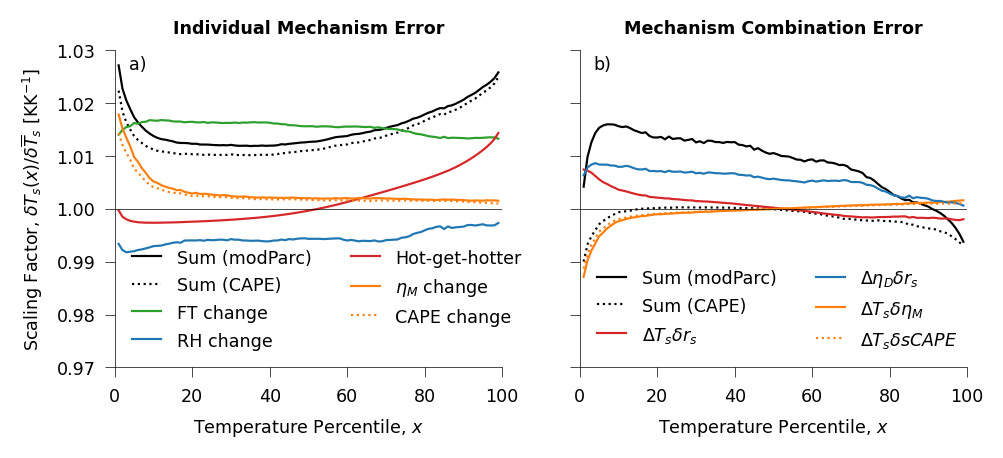

In [16]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
# fig_resize(fig, 10)
ax[0].set_title('Individual Mechanism Error', fontweight='bold')
ax[1].set_title('Mechanism Combination Error', fontweight='bold')
ax[0].plot(ds_sf_num.quant,
           np.average(ds_sf_num['scale_factor_linear'] - ds_sf['scale_factor_sum'] + 1, axis=0, weights=lat_weights),
           color='k', label='Sum (modParc)')
ax[0].plot(ds_sf_num.quant,
           np.average(ds_sf_num_cape['scale_factor_linear'] - ds_sf_cape['scale_factor_sum'] + 1, axis=0,
                      weights=lat_weights),
           color='k', linestyle=':', label='Sum (CAPE)')

ax[1].plot(ds_sf_num_cape.quant, np.average(ds_sf_num['nl_sum'], axis=0, weights=lat_weights),
           color='k', linestyle='-', label='Sum (modParc)')
ax[1].plot(ds_sf_num_cape.quant, np.average(ds_sf_num_cape['nl_sum'], axis=0, weights=lat_weights),
           color='k', linestyle=':', label='Sum (CAPE)')

# Plot individual mechanism error
for key in ds_sf:
    if 'scale_factor' in key:
        continue
    if np.nanmax(np.average(np.abs(ds_sf[key] - 1), axis=0, weights=lat_weights)) < 0.007:
        continue
    if np.nanmax(np.average(np.abs(ds_sf_num[key] - 1), axis=0, weights=lat_weights)) > 0.007:
        ax[0].plot(ds_sf.quant, np.average(ds_sf_num[key], axis=0, weights=lat_weights), label=style_map[key][2],
                   color=style_map[key][0],
                   linestyle=style_map[key][1])

# Plot combination of mechanism error
for key in ds_sf_num:
    if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key):
        continue
    if np.nanmax(np.average(np.abs(ds_sf_num[key] - 1), axis=0, weights=lat_weights)) > 0.007:
        ax[1].plot(ds_sf.quant, np.average(ds_sf_num[key], axis=0, weights=lat_weights), label=style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])

# Add the CAPE plots
key = 'sCAPE_change'
ax[0].plot(ds_sf_num_cape.quant, np.average(ds_sf_num_cape[key], axis=0, weights=lat_weights), label=style_map[key][2],
           color=style_map[key][0],
           linestyle=style_map[key][1])
key = 'nl_temp_surf_anom_sCAPE_change'
ax[1].plot(ds_sf_num_cape.quant,
           np.average(ds_sf_num_cape['nl_temp_surf_anom_sCAPE_change'], axis=0, weights=lat_weights),
           label=style_map[key][2], color=style_map[key][0], linestyle=style_map[key][1])

update_linewidth(fig)

# Reorder ax1 legend
handles, labels = ax[1].get_legend_handles_labels()
order = [0, 1, 2, 4, 3, 5]  # desired new order by index
ax[1].legend([handles[i] for i in order],
             [labels[i] for i in order], ncol=2, handlelength=leg_handlelength)

ax[0].legend(ncol=2, handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
label_subplots(fig, ax, pos_y=-2)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
update_fontsize(fig)
ax[0].set_ylim(0.97, 1.03)
plt.show()
# savefig(fig)

## Lapse rate values
Show values of the lapse rate parameters, and also include daily max data for comparison, and to comment about dry lapse rate.

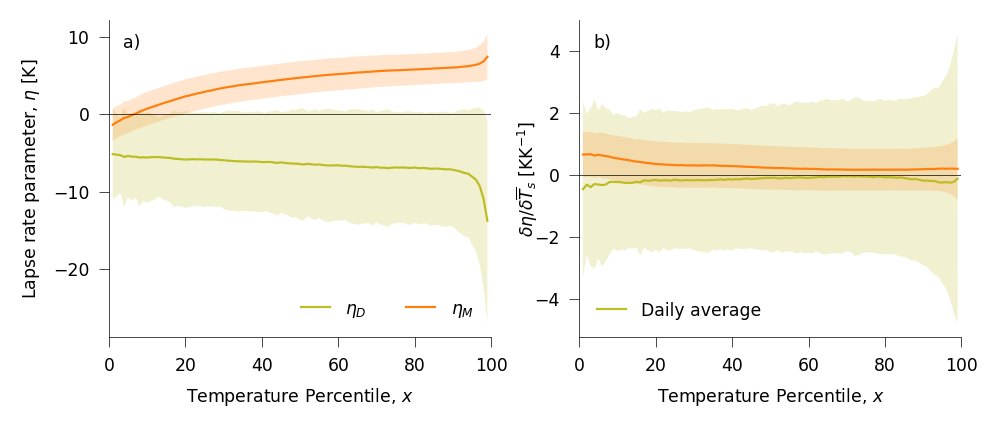

In [48]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False)
fig_resize(fig, width['two_col'])
j = 0
for i, key in enumerate(['lapse_D', 'lapse_M']):
    ax[0].plot(ds_sf.quant, np.average(ds_quant[key].isel(co2=0, surf=j), axis=1, weights=lat_weights),
               color=style_map[f'{key}_change'][0], label=['$\eta_D$', '$\eta_M$'][i])
    ax[0].fill_between(ds_sf.quant,
                       np.average((ds_quant[key] - ds_quant[f"{key}_std"]).isel(co2=0, surf=j), axis=1, weights=lat_weights),
                       np.average((ds_quant[key] + ds_quant[f"{key}_std"]).isel(co2=0, surf=j), axis=1, weights=lat_weights),
                       alpha=0.2,
                       color=style_map[f'{key}_change'][0], edgecolor="none")
    var = ds_quant[key].diff(dim='co2').squeeze() / ds_ref.TREFHT.diff(dim='co2').squeeze()
    var = var.isel(surf=j)
    ax[1].plot(ds_sf.quant, np.average(var, axis=1, weights=lat_weights), color=style_map[f'{key}_change'][0],
               label='Daily average' if i == 0 else None)
    std_diff = np.sqrt(ds_quant[f"{key}_std"].isel(co2=0) ** 2 + ds_quant[f"{key}_std"].isel(co2=1) ** 2
                       ) / ds_ref.TREFHT.diff(dim='co2').squeeze()
    std_diff = std_diff.isel(surf=j)
    ax[1].fill_between(ds_sf.quant,
                       np.average(var - std_diff, axis=1, weights=lat_weights),
                       np.average(var + std_diff, axis=1, weights=lat_weights),
                       alpha=0.2,
                       color=style_map[f'{key}_change'][0], edgecolor="none")

    # ax[0].plot(ds_sf.quant, np.average(ds_quant_daily_max[key].isel(co2=0), axis=1, weights=lat_weights),
    #            color=style_map[f'{key}_change'][0], linestyle='--')
    # ax[1].plot(ds_sf.quant, np.average(
    #     ds_quant_daily_max[key].diff(dim='tau_lw').squeeze() / ds_ref_daily_max.TREFHT.diff(dim='tau_lw').squeeze(),
    #     axis=1, weights=lat_weights),
    #            color=style_map[f'{key}_change'][0], linestyle='--', label='Daily max' if i == 0 else None)
update_linewidth(fig)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend(handlelength=leg_handlelength, ncol=2, loc='lower right')
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
label_subplots(fig, ax, box_alpha=0)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel('Lapse rate parameter, $\eta$ [K]')
ax[1].set_ylabel('$\delta \eta/ \delta \overline{T}_s$ [KK$^{-1}$]', labelpad=-2)
fig.subplots_adjust(wspace=0.23)
update_fontsize(fig)
plt.show()
# savefig(fig)

## LNB Analysis
Idea is to show that cold day amplified warming is due to more days having LNB further from surface than 500hPa

The LNB and Miyawaki 2022 plots coincide nicely indicating a regime change is taking place on these coldest days.

Can also comment on using 700hPa instead of 500hPa - say error a lot higher, and see similar change in % of days p_LNB<p_ft when using p_ft=700hPa

NOTE - THIS IS USING ALL DAYS, NOT JUST THOSE THAT ARE CONVECTIVE. MAKE IT CONVECTIVE FOR BETTER LAND PLOT

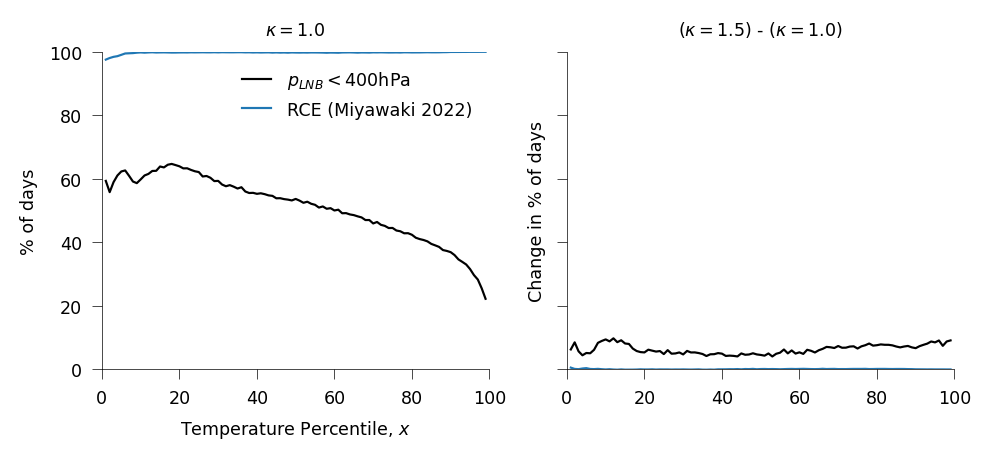

In [64]:
lapse_miy2022_M_thresh = 13  # 13% threshold value for RCE comes from paper
lnb_buoyancy_method = 'surf'
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
surf = 'land'
n_sample = (ds[surf].TREFHT>0).sum(dim='lon_sample')
for k, key in enumerate(['p_lnb_approx']):
    # for i in range(ds.tau_lw.size):
    #     # ax[0].plot(ds_sf.quant, np.average(ds_quant['p_lnb_approx'].isel(tau_lw=i), axis=1, weights=lat_weights), color=f"C{i}")
    var = (ds[surf][key] < p_ft).sum(dim='lon_sample') / n_sample
    if 'approx' in key:
        var = var.sel(parcel_type=lnb_buoyancy_method)
    ax[0].plot(ds[surf].quant, np.average(var.isel(co2=0), axis=1, weights=lat_weights)*100, color=f"k",
               linestyle=[None, '--'][k],
               label='$p_{LNB} < '+f'{p_ft/100:.0f}$hPa ')
    ax[1].plot(ds[surf].quant, np.average(var.diff(dim='co2').squeeze(), axis=1, weights=lat_weights)*100, color=f"k",
               linestyle=[None, '--'][k], )
    # Plot 700hPa values - rather than just
    # var = (ds[key]<ds700.p_ft).sum(dim='sample')/ds.sample.size
    # ax[0].plot(ds.quant, np.average(var.isel(tau_lw=0), axis=1, weights=lat_weights), color=f"C3", linestyle=[None, '--'][k])
    # ax[1].plot(ds.quant, np.average(var.diff(dim='tau_lw').squeeze(), axis=1, weights=lat_weights), color=f"C3", linestyle=[None, '--'][k])
var = (ds[surf].lapse_miy2022_M < lapse_miy2022_M_thresh).sum(dim='lon_sample') / n_sample * 100
ax[0].plot(ds[surf].quant, np.average(var.isel(co2=0), axis=1, weights=lat_weights), color=f"C0",
           label='RCE (Miyawaki 2022)')
ax[1].plot(ds[surf].quant, np.average(var.diff(dim='co2').squeeze(), axis=1, weights=lat_weights), color=f"C0")
update_linewidth(fig)
ax[0].legend(handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 100)
ax[0].set_ylabel('% of days')
ax[1].set_ylabel('Change in % of days')
ax[0].set_xlabel(percentile_label)
ax[0].set_title('$\kappa=1.0$')
ax[1].set_title('($\kappa=1.5$) - ($\kappa=1.0$)')
update_fontsize(fig)
plt.show()
# savefig(fig)

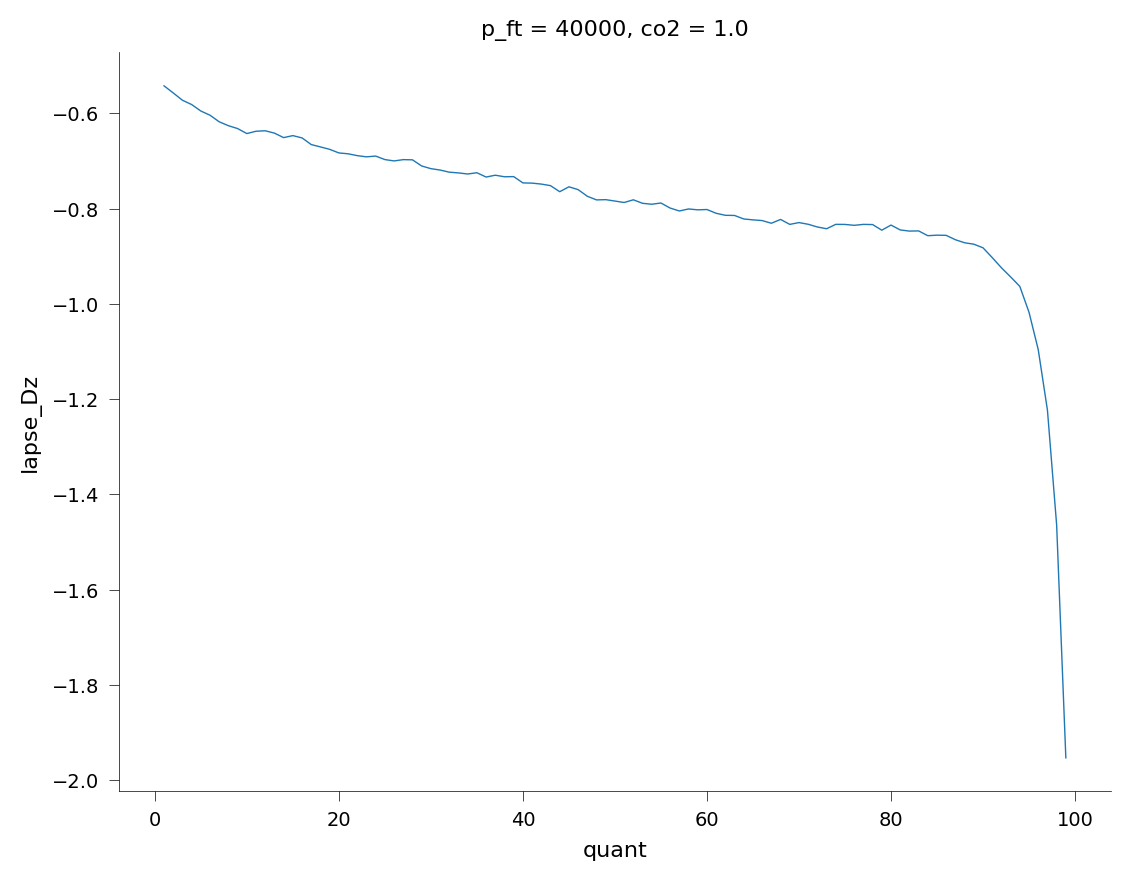

In [62]:
area_weighting(1000*ds[surf].lapse_Dz.mean(dim='lon_sample')).mean(dim='lat').isel(co2=0).plot()

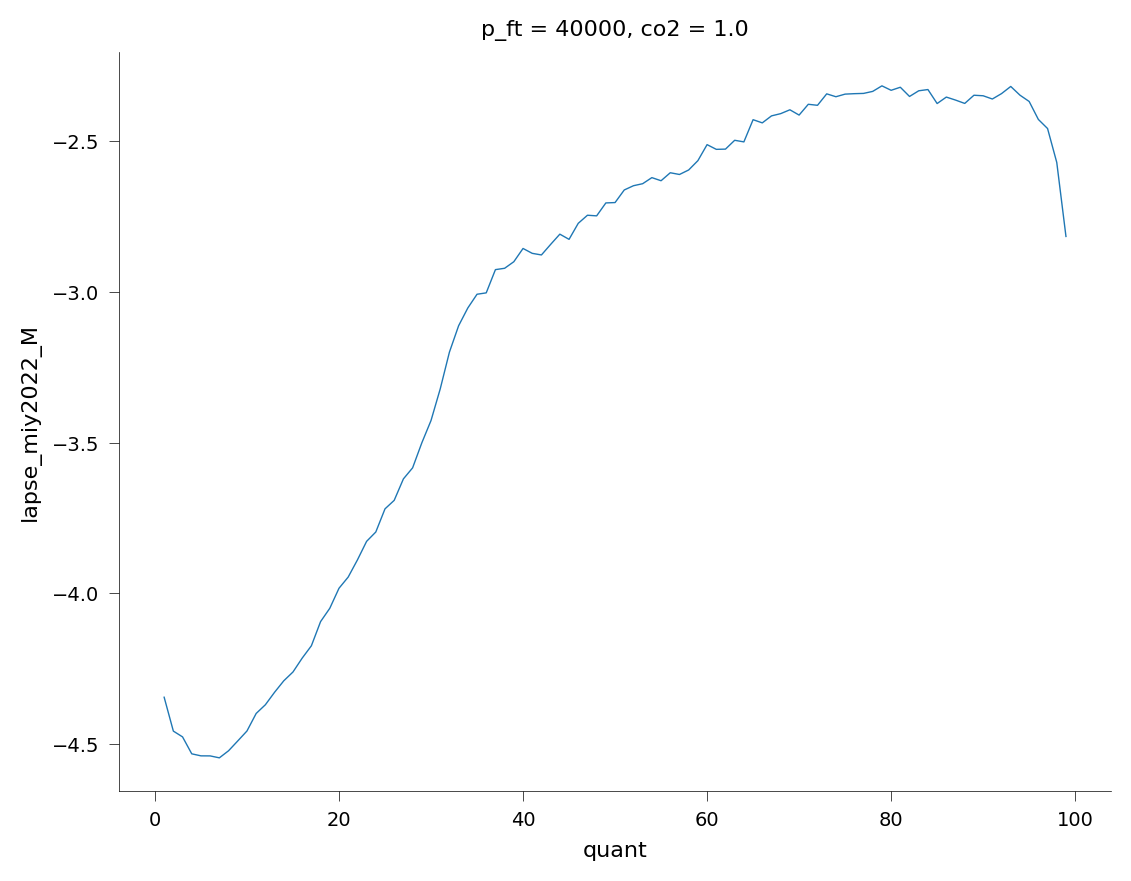

In [63]:
surf = 'ocean'
area_weighting(ds[surf].lapse_miy2022_M.mean(dim='lon_sample')).mean(dim='lat').isel(co2=0).plot()

## Miyawaki analysis

In [28]:
area_weighting(ds_quant.lapse_miy2022_M).mean(dim='lat').isel(co2=0).plot()
area_weighting(-ds_quant.lapse_miy2022_M).mean(dim='lat').diff(dim='co2').squeeze().plot()

NameError: name 'ds_quant' is not defined